# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 36

**Author 1 (sciper):** Hugo Bordereaux (302206)
**Author 2 (sciper):** Bilel El-Ghallali (296179)   
**Author 3 (sciper):** Lena Vogel (297026)   

**Release date:** 8.03.2023  
**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

..\data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images. 

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

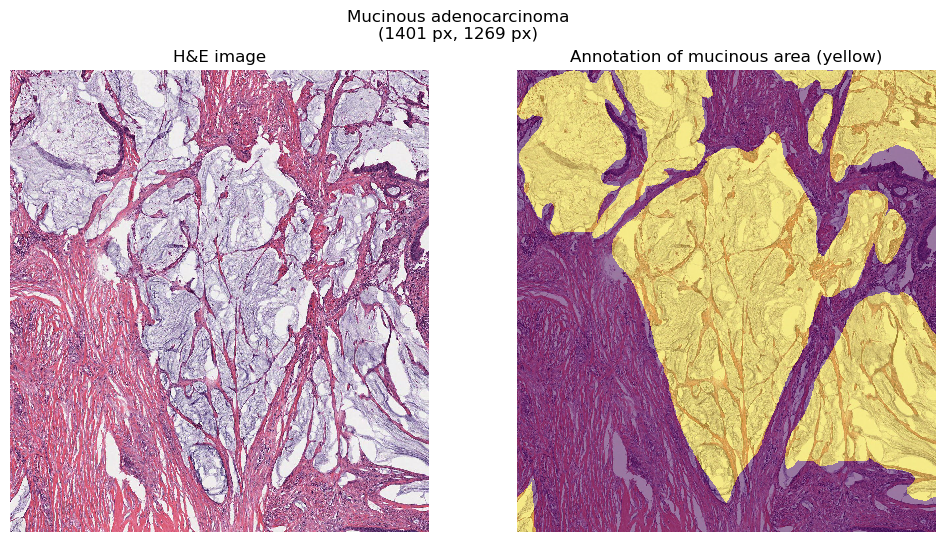

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

[(0.0, 600000.0), (0.0, 600000.0), (0.0, 600000.0), (0.0, 600000.0)]

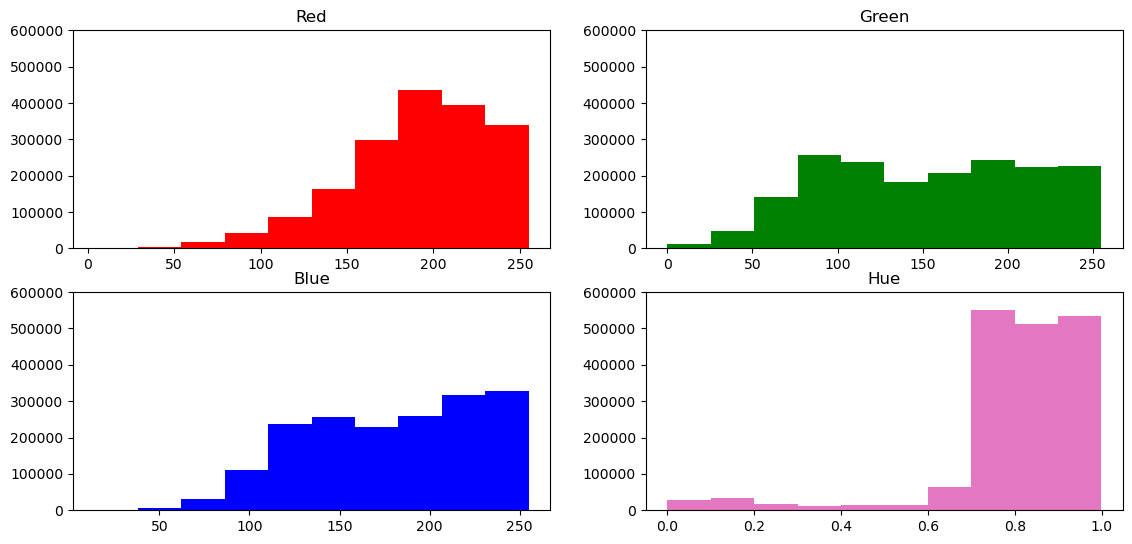

In [3]:
# Decompose the image with the 4 channels R, G, B and H (hue)
adeno_img_R = adeno_img[:,:,0]
adeno_img_G = adeno_img[:,:,1]
adeno_img_B = adeno_img[:,:,2]
adeno_img_H = skimage.color.rgb2hsv(adeno_img)[:,:,0]

# Plot the 4 pixels distributions histograms
fig,axs=plt.subplots(2,2,figsize=(12,6))
plt.subplots_adjust(bottom=0.1, right=1, top=0.9)
axs=axs.ravel()
axs[0].hist(adeno_img_R.flatten(),color="r")
axs[0].set_title("Red")

axs[1].hist(adeno_img_G.flatten(),color="g")
axs[1].set_title("Green")

axs[2].hist(adeno_img_B.flatten(),color="b")
axs[2].set_title("Blue")

axs[3].hist(adeno_img_H.flatten(),color="tab:pink")
axs[3].set_title("Hue")

# Set the same vertical scale for all plots
[axs[i].set_ylim(0,600000) for i in range(4)]

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [4]:
np.prod(adeno_img.shape)==adeno_img.size

True

In [23]:
# Find the best thresholds for each channel (note that the scale for RGB is [0,255] while for H it is [0,1])
best_ths = []
for img,name in zip([adeno_img_R,
                    adeno_img_G,
                    adeno_img_B,
                    adeno_img_H],
                    ["R","G","B","H"]):
    
    # Initialize the variables
    best_error = 1.
    best_th = 0.
    if name == "H":
        ths = np.linspace(0,1,200)
    else: 
        ths = range(256)
    
    # Find the best threshold for one channel
    for th in ths:
        img_th = img > th
        error = 1 - 1/(img.size)*np.sum(img_th==adeno_gt)
        if error < best_error:
            best_error = error
            best_th = th
    
    # Save the best threshold
    best_ths.append(best_th)     
    
    # Print the best threshold for each channel and its corresponding error value
    if name == "H": print(f"Best threshold for channel {name}: {best_th:0.3}.    error: {best_error:0.3}")
    else: print(f"Best threshold for channel {name}: {best_th}.      error: {best_error:0.3}")

Best threshold for channel R: 193.      error: 0.448
Best threshold for channel G: 145.      error: 0.262
Best threshold for channel B: 177.      error: 0.274
Best threshold for channel H: 0.0302.    error: 0.473


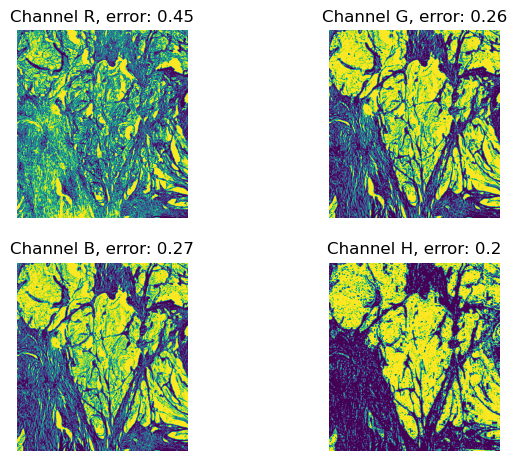

In [6]:
# Plot the segmentation only using the best threshold for each channel
fig,axs=plt.subplots(2,2)
plt.tight_layout()
for th, img, ax,name in zip(best_ths,
                       [adeno_img_R,
                        adeno_img_G,
                        adeno_img_B,
                        1-adeno_img_H],
                        axs.ravel(),
                        ["R","G","B","H"]):
    img_th = img > th
    ax.axis('off')
    ax.imshow(img_th)
    error = 1 - 1/(img.size)*np.sum(img_th==adeno_gt)
    ax.set_title(f"Channel {name}, error: {error:0.2}")

#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [7]:
# TODO: replace variable with your own threshod
mask_thesholding = 1-adeno_img_H > best_ths[3]

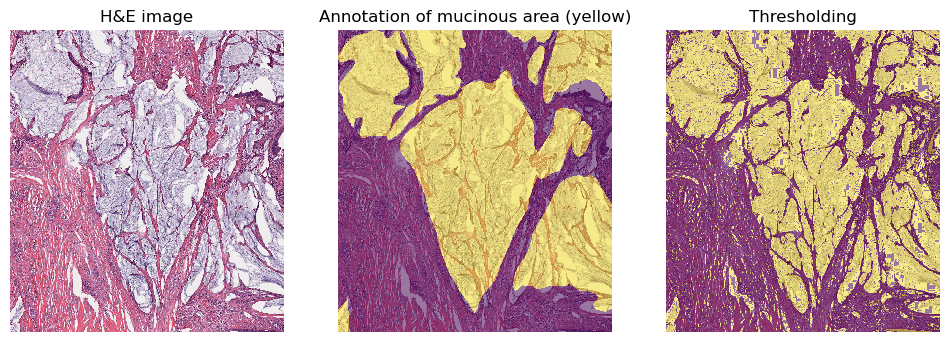

In [8]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot images
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(adeno_img, interpolation='nearest')
ax[2].imshow(mask_thesholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. Save the mask as the variable `mask_morph`

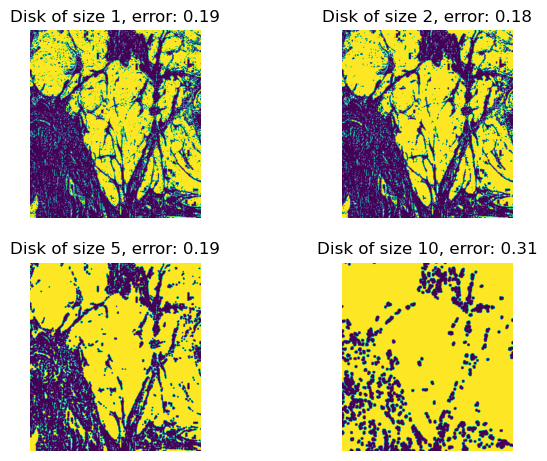

In [9]:
# TODO A : Closing with disk size of 1, 2, 5, 10

fig,axs=plt.subplots(2,2)
plt.tight_layout()
for size, ax in zip([1,2,5,10], axs.ravel()):
    closed = skimage.morphology.closing(mask_thesholding, skimage.morphology.disk(size))
    ax.axis('off')
    ax.imshow(closed)
    error = 1 - 1/(img.size)*np.sum(closed==adeno_gt)
    ax.set_title(f"Disk of size {size}, error: {error:0.2}")

We observe that the larger the disk is, the more dilated becomes the region of mucinous area. The smallest objects become larger.  The ideal disk size is 2.

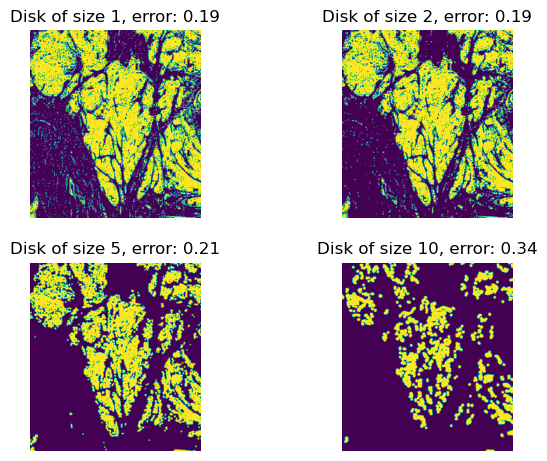

In [10]:
# TODO A : Opening with disk size of 1, 2, 5, 10

fig,axs=plt.subplots(2,2)
plt.tight_layout()
for size, ax in zip([1,2,5,10], axs.ravel()):
    opened = skimage.morphology.opening(mask_thesholding, skimage.morphology.disk(size))
    ax.axis('off')
    ax.imshow(opened)
    error = 1 - 1/(img.size)*np.sum(opened==adeno_gt)
    ax.set_title(f"Disk of size {size}, error: {error:0.2}")

Here, the inverse happens: The small objects disappear when the disk becomes bigger, and the gaps between the regions of mucinous area become larger.
The ideal disk size is 2.

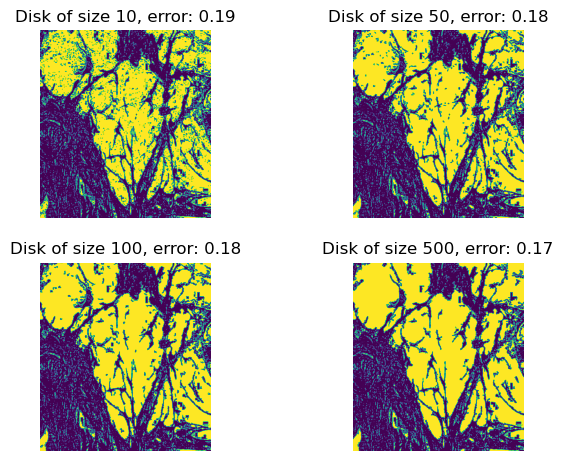

In [11]:
# TODO B : Removing holes with disk size of 10, 50, 100, 500

fig,axs=plt.subplots(2,2)
plt.tight_layout()
for size, ax in zip([10,50,100,500], axs.ravel()):
    removed_holes = skimage.morphology.remove_small_holes(mask_thesholding, size)
    ax.axis('off')
    ax.imshow(removed_holes)
    error = 1 - 1/(img.size)*np.sum(removed_holes==adeno_gt)
    ax.set_title(f"Disk of size {size}, error: {error:0.2}")

The region of mucinous area is more uniform when the disk is larger. 

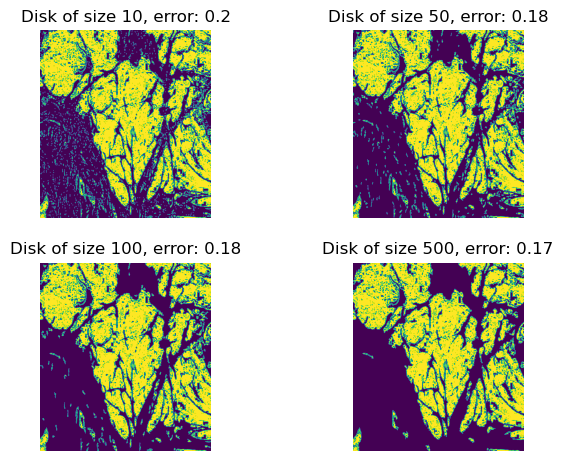

In [12]:
# TODO B : Removing small objects with disk size of 10, 50, 100, 500

fig,axs=plt.subplots(2,2)
plt.tight_layout()
for size, ax in zip([10,50,100,500], axs.ravel()):
    removed_objects = skimage.morphology.remove_small_objects(mask_thesholding, size)
    ax.axis('off')
    ax.imshow(removed_objects)
    error = 1 - 1/(img.size)*np.sum(removed_objects==adeno_gt)
    ax.set_title(f"Disk of size {size}, error: {error:0.2}")

Same as when removing the holes: The background is more uniform when the disk is larger, which is what we aim to do. 

The best error we had is 0.109.


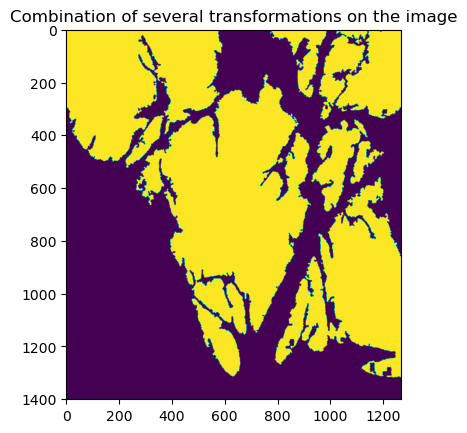

In [13]:
# TODO C : Finding a good combination of the different treatments.

# Optimized image treatments with closing and opening followed by hole filling and small objects removing
closing_size = 2
opening_size = 2
hole_size = 10000
object_size = 7000

closed_image = skimage.morphology.closing(mask_thesholding, skimage.morphology.disk(closing_size))
opened_image = skimage.morphology.opening(closed_image, skimage.morphology.disk(opening_size))
removed_holes_image = skimage.morphology.remove_small_holes(opened_image, hole_size)
mask_morph = skimage.morphology.remove_small_objects(removed_holes_image, object_size)
plt.title("Combination of several transformations on the image")
plt.imshow(mask_morph)

# Calculate the corresponding error
error = 1 - 1/(img.size)*np.sum(mask_morph==adeno_gt)
print(f"The best error we had is {error:0.3}.")

The best error we obtained (0.109) was by combining all the treatments and testing several sizes.

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

In [14]:
import numpy as np
from queue import Queue

def region_growing(image, seed_point, threshold):
    """
    Applies region growing algorithm to a color image with given seed point and threshold on hue values.
    Returns a binary mask indicating the segmented region.
    """
    # Initialize mask and visited matrix
    mask = np.zeros(image.shape[:2], dtype=bool)
    visited = np.zeros(image.shape[:2], dtype=bool)

    # Initialize queue with seed point
    q = Queue()
    q.put(seed_point)

    # Region growing loop
    while not q.empty():
        # Get next point from queue
        current_point = q.get()

        # Check if point has already been visited
        if visited[current_point]:
            continue

        # Check hue difference and add to mask and queue if within threshold
        hue_diff = abs(image[current_point] - image[seed_point])
        if hue_diff > 0.5:
            hue_diff = 1 - hue_diff
        if hue_diff <= threshold:
            visited[current_point] = True
            mask[current_point] = True
            # Check neighbors and add to queue if within threshold
            for neighbor in get_neighbors(current_point, image.shape[:2]):
                if visited[neighbor]:
                    continue
                neighbor_hue_diff = abs(image[neighbor] - image[seed_point])
                if neighbor_hue_diff > 0.5:
                    neighbor_hue_diff = 100 - neighbor_hue_diff
                if neighbor_hue_diff <= threshold:
                    q.put(neighbor)

    return mask

def get_neighbors(point, shape):
    """
    Returns a list of neighbor coordinates for a given point in an array of given shape.
    """
    x, y = point
    neighbors = []
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            nx, ny = x + dx, y + dy
            if nx >= 0 and ny >= 0 and nx < shape[0] and ny < shape[1]:
                neighbors.append((nx, ny))
    return neighbors

In [15]:
seed = (700, 600)
#Check if the seed is True in the ground truth
print(adeno_gt[seed])
#Check hue value of the seed
print(1-adeno_img_H[seed])

True
0.24479166666666663


In [16]:
adeno_img_H.shape[:2]

(1401, 1269)

In [1]:
#Initialize the result mask
mask_region = np.zeros_like(adeno_gt)
mask_region = region_growing(1-adeno_img_H, seed, 0.13)

#show adeno_gt and adeno_img
fig,axs=plt.subplots(1,2,figsize=(12,6))
axs[0].imshow(adeno_gt)
axs[1].imshow(mask_region)

NameError: name 'np' is not defined

---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

In [18]:
# Add your comments here

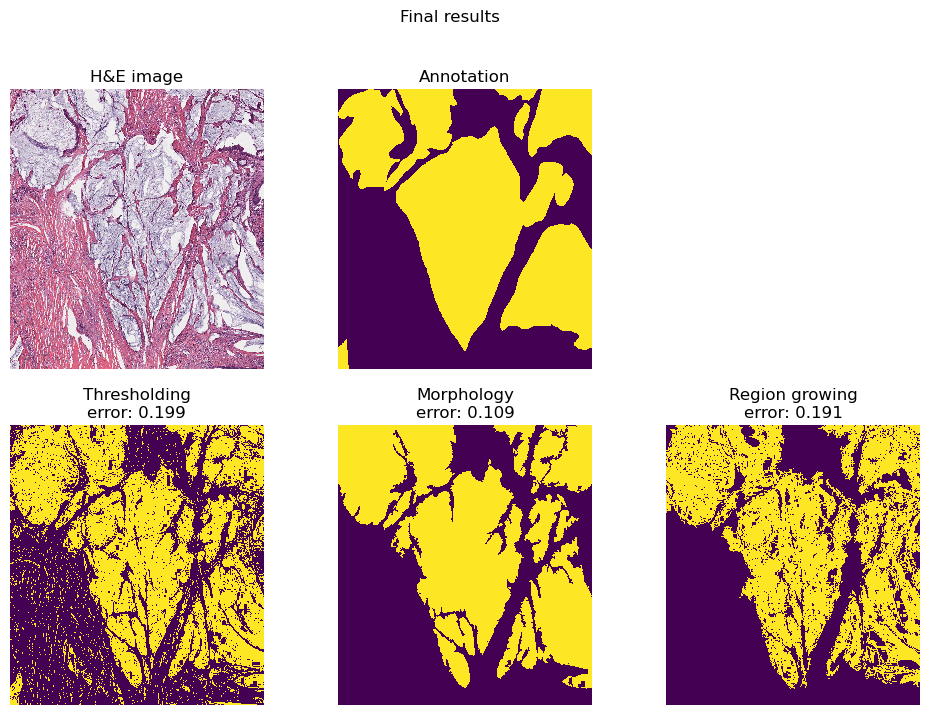

In [19]:
error_th = 1- (mask_thesholding == adeno_gt).mean()
error_morph = 1- (mask_morph == adeno_gt).mean()
error_region = 1- (mask_region == adeno_gt).mean()


# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thesholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))


# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))


[a.axis('off') for a in ax.ravel()]


plt.suptitle("Final results")
plt.show()

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 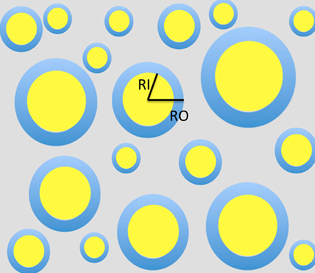

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 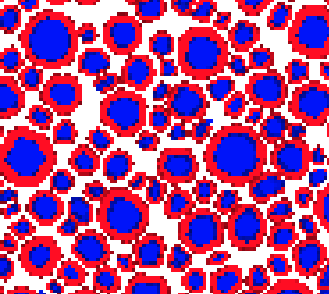

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**
    Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [20]:
data_base_path

'..\\data'

In [21]:
import cv2
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/' 

files = ["GT_0.png"  , "test_0_0.png" , "test_0_1.png"]
gt_0 = cv2.imread(path_folder+ files[0])
snr_10 = cv2.imread(path_folder+ files[1])
snr_3 = cv2.imread(path_folder+ files[2])

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig,axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

ModuleNotFoundError: No module named 'cv2'

### 2.1.1 Preprocessing 

 % add your images after preprocessing


In [ ]:
# Plot the pixels distribution for the GT, SNR10 and SNR3
fig,axes = plt.subplots(1, 3, figsize=(24, 5))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.hist(im.flatten(),color="grey")
    #ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
# Set the 3 values of the GT
values = [30, 150, 230]

# Set the 2 thresholds
th_snr_10 = [50, 175]
th_snr_3  = [50, 175]

sizes_snr_10 = [1,1,5,2]
sizes_snr_3  = [1,1,5,2]

def part_image(img,thresholds,sizes):    
    img_outer = snr_10[:,:,0] < thresholds[0]
    img_all = snr_10[:,:,0] < thresholds[1]

    for i,j in zip(range(img_outer.shape[0]), range(img_outer.shape[1])):
        if img_outer[i,j]: img_outer[i,j] = values[0]
        elif not img_outer[i,j]: img_outer[i,j] = values[2]
        if img_all[i,j]: img_all[i,j] = values[2]
        elif not img_all[i,j]: img_all[i,j] = values[0]   

    img_inner = img_all ^ img_outer

    # Plot the 3 images
    imgs = [img_inner,img_outer,img_all]
    imgs_names = ["Inner part", "Outer part","Whole axones"]

    fig,axes=plt.subplots(1,3,figsize=(24,24))
    for ax,img,img_name in zip(axes,imgs,imgs_names):
        #closed_image = skimage.morphology.closing(img, skimage.morphology.disk(sizes[0]))
        #opened_image = skimage.morphology.opening(closed_image, skimage.morphology.disk(sizes[1]))
        removed_holes_image = skimage.morphology.remove_small_holes(img, sizes[2])
        mask_morph = skimage.morphology.remove_small_objects(removed_holes_image, sizes[3])
        ax.axis("off")
        ax.set_title(img_name)
        ax.imshow(mask_morph[0:512,0:512])
    
    return(img_inner, img_outer, img_all)

In [ ]:
# SNR 10 segmentation
snr_10_inner, snr_10_outer, snr_10_all = part_image(snr_10, th_snr_10, sizes_snr_10)

In [ ]:
# SNR 3 segmentation
snr_3_inner, snr_3_outer, snr_3_all = part_image(snr_3, th_snr_3, sizes_snr_3)

In [ ]:
colored_snr_10 = ...


### 2.1.2 Results Segmetations

In [ ]:
images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(255- im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.3 Radii histrograms 

In [ ]:
## results Radii distribution. proposal feel free to change it
import numpy as np


rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)


rads_gt = [ rads_inner ,rads_outer]
rads_test0 = [ rads_inner ,rads_outer]  # your result
rads_test1 = [ rads_inner ,rads_outer]  # your result

all_rads= [rads_gt , rads_test0 , rads_test1] 

images = [gt_0 , snr_10, snr_3]
im_names = ["GT" , "SNR 10" , "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0]  , color = "red" , label = "inner" ,alpha= 0.5)
    ax.hist(rads[1]  , color = "blue" , label = "outer" ,alpha= 0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

In [ ]:

files = ["GT_3.png"  , "test_3_0.png" , "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder+ files[0])
lowfreq0 = cv2.imread(path_folder+ files[1])
lowfreq1 = cv2.imread(path_folder+ files[2])

images = [gt_3 , lowfreq0, lowfreq1]
im_names = ["GT" , "Low " , "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512,0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.1 Preprocessing

### 2.2.2 Results Segmetations

### 2.2.3 Radii histrograms


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

In [ ]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png" ]
real_data = cv2.imread(path_folder+ files[0])

plt.imshow(real_data[:256, :256])